In [1]:
from collections import Counter
import os
import re

from huggingface_hub import login
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# authentication with huggingface
# !pip install ipywidgets
# request data access at https://huggingface.co/datasets/Cofacts/line-msg-fact-check-tw
# create token at https://huggingface.co/settings/tokens (create as read)
# token should be stored locally, so technically login is only needed one time
login()

In [3]:
# download specific dataset files; entire archive is only ~250 mb
articles = load_dataset("Cofacts/line-msg-fact-check-tw", "articles") # article contents and some meta info
article_replies = load_dataset("Cofacts/line-msg-fact-check-tw", "article_replies") # 'join table' for articles and replies with added meta info
article_categories = load_dataset("Cofacts/line-msg-fact-check-tw", "article_categories")
art_rep_df = pd.merge(
    articles["train"].to_pandas(),
    article_replies["train"].to_pandas(),
    left_on="id",
    right_on="articleId",
    how="inner"
)
art_rep_cat_df = pd.merge(
    art_rep_df,
    article_categories["train"].to_pandas(),
    left_on="id",
    right_on="articleId",
    how="inner"
)
art_rep_cat_df.head()
# replyType is the label assigned to an article by human editor

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,categoryId,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt
0,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,medical,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-05T06:14:26.748Z,2022-09-05T06:14:26.748Z
1,14h550ymn3m3u,TEXT,NORMAL,BA.5病毒引發的不只「縮短潛伏期，增加R0值」，還有易使人「再感染（Reinfecion）...,1.0,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.360Z,2022-09-05T05:26:33.381Z,3753ca22ca96f5fc1f13e62291f28e405d56b1a976b21d...,RUMORS_LINE_BOT,...,covid19,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-05T06:14:27.657Z,2022-09-05T06:14:27.657Z
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班\n\n2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,1.0,bow,11db1c28d9380b6b177b0e5646faa60f7df687c5edaf4c...,DEVELOPMENT_BACKEND,0,0,NORMAL,2021-11-21T17:34:28.958Z,2021-11-21T17:34:28.958Z
3,my5ep5z69tql,TEXT,NORMAL,你好👱🏻‍♀️\n\n簡單跟你說一下公司工作內容：\n我們是做購物系統訂單的工作，主要就是增...,1.0,2022-08-11T20:53:15.644Z,2022-08-11T20:53:15.644Z,2022-09-07T11:02:00.344Z,8a8a319bea0b3bff580d8507ae6470ba37e87791171886...,RUMORS_LINE_BOT,...,nD2n7nEBrIRcahlYwQoW,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-08-12T05:52:28.775Z,2022-08-12T05:52:28.775Z
4,3dnh713ikpf3c,TEXT,NORMAL,先和你簡單介紹\n我們誠徵線上打工小幫手\n工作內容有：聽寫打字、頁面排版、商品評論刷流量、...,1.0,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.742Z,2022-09-07T10:10:41.761Z,47e90b2538a5615b323f50571b77d91f7f105e55684aa1...,RUMORS_LINE_BOT,...,nD2n7nEBrIRcahlYwQoW,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-08T05:31:35.081Z,2022-09-08T05:31:35.081Z


In [4]:
article_replies

DatasetDict({
    train: Dataset({
        features: ['articleId', 'replyId', 'userIdsha256', 'negativeFeedbackCount', 'positiveFeedbackCount', 'replyType', 'appId', 'status', 'createdAt', 'updatedAt'],
        num_rows: 90406
    })
})

In [5]:
# intl
# oT2o7nEBrIRcahlYKQoM
# kj287XEBrIRcahlYvQoS

# lj2m7nEBrIRcahlY6Ao_ (maybe)

political = ["intl", "oT2o7nEBrIRcahlYKQoM", "kj287XEBrIRcahlYvQoS"]
political_cofacts = art_rep_cat_df[art_rep_cat_df["categoryId"].isin(political)]
political_cofacts = political_cofacts[political_cofacts["replyType"] != "NOT_ARTICLE"]
len(political_cofacts)

19564

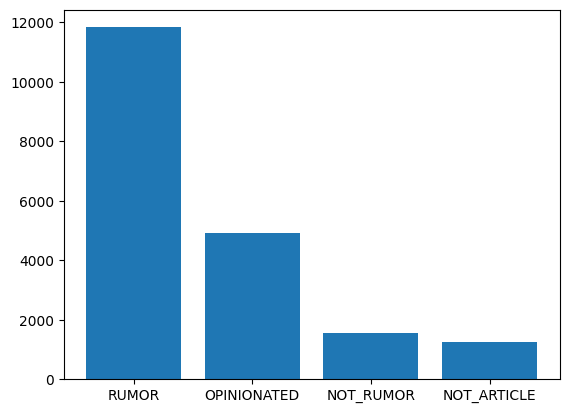

replyType
RUMOR          11832
OPINIONATED     4907
NOT_RUMOR       1559
NOT_ARTICLE     1266
Name: count, dtype: int64


In [6]:
# imbalance
lab_counts = political_cofacts["replyType"].value_counts()
plt.bar(lab_counts.index, lab_counts.values)
plt.show()
print(lab_counts)

In [7]:
def get_max_length(texts: list):
    max_length = 0
    for t in texts:
        if t:
            max_length = max(max_length, len(t))
    return max_length

def inspect_dist(col: list, threshold = 0):
    if threshold == 0:
        plt.hist(col, bins=100)
        plt.show()
    else:
        plt.hist(col[col <= threshold], bins=100)
        plt.show()
        print(f"Remaining datapoints: {len(col[col <= threshold]) / len(col)}")

In [8]:
get_max_length(political_cofacts["text"])

10000

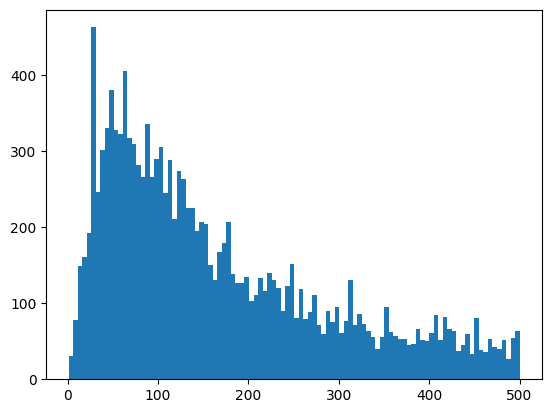

Remaining datapoints: 0.7170540638045663


In [9]:
inspect_dist(political_cofacts["text"].dropna().apply(len), threshold=500)

In [10]:
political_cofacts[political_cofacts["text"].str.len() == 28]
# NOTE: remove urls

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,categoryId,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt
270,2kxll2eyjhpz4,TEXT,NORMAL,https://youtu.be/Lpfzjj0_fqI,0.0,2022-04-10T15:43:25.690Z,2022-04-10T15:43:25.690Z,2022-04-10T15:46:30.254Z,125fdde83e341728a44e2ac2a2fbd42e0935279626e0b5...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-04-11T03:53:57.752Z,2022-04-11T03:53:57.752Z
352,382yifa6357oz,TEXT,NORMAL,中國大陸的拖吊車！\n看看人家多進步….台灣真是井底之蛙！,1.0,2022-09-01T04:59:46.953Z,2022-09-01T04:59:46.953Z,2022-09-02T14:59:23.980Z,1c0dbb74934331bf03405ab871e6b429a697cbf06e611b...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-09-01T12:01:45.563Z,2022-09-01T12:01:45.563Z
417,105rgiyskma65,TEXT,NORMAL,https://youtu.be/Eldm7ZaXfN0,1.0,2022-09-04T05:10:20.725Z,2022-09-04T05:10:20.725Z,2022-09-06T00:10:55.219Z,b9b3ec3efb9a9632ab92a62e3c01865f62578d2db10bb4...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,0,NORMAL,2022-09-04T11:24:48.765Z,2022-09-04T11:24:48.765Z
418,105rgiyskma65,TEXT,NORMAL,https://youtu.be/Eldm7ZaXfN0,1.0,2022-09-04T05:10:20.725Z,2022-09-04T05:10:20.725Z,2022-09-06T00:10:55.219Z,b9b3ec3efb9a9632ab92a62e3c01865f62578d2db10bb4...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,0,NORMAL,2022-09-04T11:24:54.920Z,2022-09-04T11:24:54.920Z
712,324p4t3ostnfv,TEXT,NORMAL,https://youtu.be/BycaC5FxgiE,1.0,2022-07-21T01:39:17.373Z,2022-07-21T01:39:17.373Z,2022-07-28T11:45:24.054Z,16b9f4cf813f55ea6186ed007b07d46b821f4cc329f885...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-07-21T16:30:47.171Z,2022-07-21T16:30:47.171Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96027,1qm4jttwezxwc,TEXT,NORMAL,有夠離譜，從紙箱夾層拉出一大堆票！有請大家廣發揭露！！！,1.0,2024-01-19T06:41:52.059Z,2024-01-19T06:41:52.059Z,2024-01-19T06:41:52.069Z,e9d23c5fbae20f47911888299fe2a1f9dc009455f5e289...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-19T14:43:59.257Z,2024-01-19T14:43:59.257Z
96994,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-03T14:05:32.284Z,2024-01-03T14:05:32.284Z
96995,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-03T14:05:32.284Z,2024-01-03T14:05:32.284Z
96996,2nn9hdhq0i5ds,TEXT,NORMAL,全世界都知道賴清德養小三叫莊雅芬、生了一個私生子叫賴庭瀚,1.0,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.287Z,2024-01-03T13:27:29.298Z,ba2fe1c2638275dde1c566a384aa2f4d9f88940ef61191...,RUMORS_LINE_BOT,...,oT2o7nEBrIRcahlYKQoM,NaN,None,d7a460c01f3f7bd926f40280e81445de0d72d2b140fe8b...,WEBSITE,0,0,NORMAL,2024-01-03T14:05:32.284Z,2024-01-03T14:05:32.284Z


In [11]:
# https://symbl.cc/en/unicode/blocks/

# retain
# chinese block: \u4E00-\u9FFF
# cjk punctuation: \u3000-\u303F
# ascii block: \u0000-\u007F
# general punctuation: \u2000-\u206F
# halfwidth punctuation: \uFF00-\uFF65

# preserve other scripts? (japanese, korean, thai, ...)
# presentation form punctuation: \uFE00-\uFFFF
# mathematical operators: \u2200-\u22FF

# discard
# \u1F000-\u1FBFF
# dingdats: \u2700-\u27BF
# emojis: \u1F600-\u1F64F

In [12]:
### Preprocessing so far

def remove_url(text: str):
    regex = r"https?\S+|\S*\.com\S*"
    text = re.sub("\n", " ", text) # also remove newlines. Beware trailing whitespaces
    text = re.sub(regex, "", text)
    if len(text) == 0:
        text = pd.NA
    return text

def filter_unicodes(texts: list):
    retain = list()
    remove = list()
    for t in texts:
        if pd.notna(t):
            regex = re.compile(r"[^\u4E00-\u9FFF\u3000-\u303F\u0000-\u007F\u2000-\u206F\uFF00-\uFF65]")
            filtered_txt = regex.sub("", t)
            retain.append(filtered_txt)
            deleted = regex.findall(t)
            remove.append(deleted)
        else:
            retain.append(t)
    remove = Counter([i for l in remove for i in l])
    return retain, remove

def find_unicodes(chars: list):
    out = {char : char.encode("unicode_escape") for char in chars}
    return out

# processing steps
clean_df = political_cofacts.copy()
clean_df = clean_df[clean_df["replyType"] != "NOT_ARTICLE"] # remove non articles
clean_df = clean_df.dropna(subset=["text", "replyType"]) # drop na's
clean_df["text"] = clean_df["text"].apply(remove_url) # delete urls
clean_df["text"], remove = filter_unicodes(clean_df["text"]) # filter for chinese and latin script
clean_df = clean_df.dropna(subset=["text", "replyType"])
clean_df.head()
# still some user ids, urls with uncommon domains

,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,categoryId,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班 2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，我站...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,1.0,bow,11db1c28d9380b6b177b0e5646faa60f7df687c5edaf4c...,DEVELOPMENT_BACKEND,0,0,NORMAL,2021-11-21T17:34:28.958Z,2021-11-21T17:34:28.958Z
12,2gf5rwls4alux,TEXT,NORMAL,柬埔寨活摘器官像屠宰場難以想像告訴周圍的朋友別為了錢去柬埔寨,2.0,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.950Z,17157db98067221ce5bc87e2cfd6aa140db2ae7a5aba05...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-08-13T15:36:22.208Z,2022-08-13T15:36:22.208Z
20,1be7unngzm4hj,TEXT,NORMAL,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,2.0,2022-02-03T13:25:32.338Z,2022-02-03T13:25:32.338Z,2022-02-03T15:45:44.906Z,862d08a9739e3b750cc428fc11c1cd7c19411cea79a832...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-02-03T13:40:22.100Z,2022-02-03T13:40:22.100Z
22,1be7unngzm4hj,TEXT,NORMAL,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,2.0,2022-02-03T13:25:32.338Z,2022-02-03T13:25:32.338Z,2022-02-03T15:45:44.906Z,862d08a9739e3b750cc428fc11c1cd7c19411cea79a832...,RUMORS_LINE_BOT,...,intl,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-02-03T13:40:22.100Z,2022-02-03T13:40:22.100Z
23,3h85z5df0rcgq,TEXT,NORMAL,"CDC已承認失敗！！！ 事到如今，我们该何去何从？ 斯图尔特坦克斯利博士： ""科学已經很明...",1.0,2022-08-27T03:24:59.219Z,2022-08-27T03:24:59.219Z,2022-08-27T03:24:59.243Z,993c8c5b07c5db250f3cc27cd6fab5d95b5edab4681d34...,RUMORS_LINE_BOT,...,kj287XEBrIRcahlYvQoS,NaN,None,3394772103f66782649fa537b40a9dc3346e2f562f42a4...,WEBSITE,0,0,NORMAL,2022-08-29T13:54:36.342Z,2022-08-29T13:54:36.342Z


In [13]:
find_unicodes([c[0] for c in remove.most_common()])

{'﹔': b'\\ufe54',
 '﹐': b'\\ufe50',
 'о': b'\\u043e',
 '⋯': b'\\u22ef',
 'а': b'\\u0430',
 '\xa0': b'\\xa0',
 'т': b'\\u0442',
 'е': b'\\u0435',
 'с': b'\\u0441',
 'и': b'\\u0438',
 'н': b'\\u043d',
 'р': b'\\u0440',
 'в': b'\\u0432',
 '️': b'\\ufe0f',
 'у': b'\\u0443',
 'м': b'\\u043c',
 '·': b'\\xb7',
 'д': b'\\u0434',
 'к': b'\\u043a',
 'п': b'\\u043f',
 'い': b'\\u3044',
 'б': b'\\u0431',
 'л': b'\\u043b',
 'に': b'\\u306b',
 'я': b'\\u044f',
 'の': b'\\u306e',
 'г': b'\\u0433',
 'な': b'\\u306a',
 '\ufeff': b'\\ufeff',
 'と': b'\\u3068',
 'を': b'\\u3092',
 'ㄧ': b'\\u3127',
 'す': b'\\u3059',
 'ю': b'\\u044e',
 'で': b'\\u3067',
 'ь': b'\\u044c',
 '─': b'\\u2500',
 '﹗': b'\\ufe57',
 'た': b'\\u305f',
 'ы': b'\\u044b',
 'ﻫ': b'\\ufeeb',
 'か': b'\\u304b',
 'て': b'\\u3066',
 'з': b'\\u0437',
 'こ': b'\\u3053',
 'ま': b'\\u307e',
 '￼': b'\\ufffc',
 'し': b'\\u3057',
 'は': b'\\u306f',
 '⃣': b'\\u20e3',
 '○': b'\\u25cb',
 'й': b'\\u0439',
 'も': b'\\u3082',
 'が': b'\\u304c',
 'ш': b'\\u0448',
 'ч': 

In [14]:
### putting it all together
def filter_unicodes(text: str):
    if pd.notna(text):
        text = re.sub("\n", " ", text)
        regex_urls = r"https?\S+|\S*\.com\S*"
        text = re.sub(regex_urls, "", text)
        if text.strip():
            regex_han_ascii = re.compile(r"[^\u4E00-\u9FFF\u3000-\u303F\u0000-\u007F\u2000-\u206F\uFF00-\uFF65]")
            text = regex_han_ascii.sub("", text)
            if not text.strip():
                text = pd.NA
        else:
            text = pd.NA
    return text


label_dict = {
    "NOT_RUMOR": 0,
    "OPINIONATED" : 1,
    "RUMOR" : 2
}

political_cofacts["label"] = political_cofacts["replyType"].map(label_dict)
political_cofacts["text"] = political_cofacts["text"].apply(filter_unicodes)
political_cofacts = political_cofacts.dropna(subset=["text", "replyType"])
political_cofacts.head()

/tmp/ipykernel_11661/314385836.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_cofacts["label"] = political_cofacts["replyType"].map(label_dict)
/tmp/ipykernel_11661/314385836.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  political_cofacts["text"] = political_cofacts["text"].apply(filter_unicodes)


,id,articleType,status_x,text,normalArticleReplyCount,createdAt_x,updatedAt_x,lastRequestedAt,userIdsha256_x,appId_x,...,aiConfidence,aiModel,userIdsha,appId,negativeFeedbackCount_y,positiveFeedbackCount_y,status,createdAt,updatedAt,label
2,oupi0eu9aocr,TEXT,NORMAL,被取消的航班 2018年的一天，我從洛杉磯回國，乘坐凌晨一點的國航航班，馬上要登機了，我站...,1.0,2021-11-13T16:36:56.548Z,2021-11-13T16:36:56.548Z,2022-04-27T08:52:17.115Z,4a266a6fdefc88e59eef644402e97c7f4c8196becca686...,RUMORS_LINE_BOT,...,1.0,bow,11db1c28d9380b6b177b0e5646faa60f7df687c5edaf4c...,DEVELOPMENT_BACKEND,0,0,NORMAL,2021-11-21T17:34:28.958Z,2021-11-21T17:34:28.958Z,1.0
10,2gf5rwls4alux,TEXT,NORMAL,柬埔寨活摘器官像屠宰場難以想像告訴周圍的朋友別為了錢去柬埔寨,2.0,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.950Z,17157db98067221ce5bc87e2cfd6aa140db2ae7a5aba05...,RUMORS_LINE_BOT,...,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-08-13T15:36:22.208Z,2022-08-13T15:36:22.208Z,NaN
12,2gf5rwls4alux,TEXT,NORMAL,柬埔寨活摘器官像屠宰場難以想像告訴周圍的朋友別為了錢去柬埔寨,2.0,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.929Z,2022-08-13T07:08:52.950Z,17157db98067221ce5bc87e2cfd6aa140db2ae7a5aba05...,RUMORS_LINE_BOT,...,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-08-13T15:36:22.208Z,2022-08-13T15:36:22.208Z,2.0
20,1be7unngzm4hj,TEXT,NORMAL,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,2.0,2022-02-03T13:25:32.338Z,2022-02-03T13:25:32.338Z,2022-02-03T15:45:44.906Z,862d08a9739e3b750cc428fc11c1cd7c19411cea79a832...,RUMORS_LINE_BOT,...,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-02-03T13:40:22.100Z,2022-02-03T13:40:22.100Z,2.0
22,1be7unngzm4hj,TEXT,NORMAL,［重要消息］ 以下國家宣布取消所有檢疫程序、新冠病毒檢測和強制接種疫苗，並認為新冠病毒只是...,2.0,2022-02-03T13:25:32.338Z,2022-02-03T13:25:32.338Z,2022-02-03T15:45:44.906Z,862d08a9739e3b750cc428fc11c1cd7c19411cea79a832...,RUMORS_LINE_BOT,...,NaN,None,fff8d0d025ed96128c04969d5552a6642c8b2fb04e3ccb...,WEBSITE,0,0,NORMAL,2022-02-03T13:40:22.100Z,2022-02-03T13:40:22.100Z,2.0
